**Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

### Titanic Passenger data set
We'll be working with the Titanic passenger dataset to build a classification model to predict whether a passenger survied the sinking of the Titanic.  
Here is the data dictionary:

| Variable   |	Definition   |
 |:------|:--------------------------------|
 |survived | survived? 0 = No, 1 = yes  |
 |pclass | Ticket class (int)  |
 |sex	 |sex |
 |age	 | age in years  |
 |sibsp  |	# of siblings / spouses aboard the Titanic |
 |parch  |	# of parents / children aboard the Titanic |
 |fare   |	Passenger fare   |
 |embarked | Port of Embarkation |
 |class  |Ticket class (obj)   |
 |who    | man, woman, or child  |
 |adult_male | True/False |
 |alive  | yes/no  |
 |alone  | yes/no  |


**Load Datasets**

In [4]:
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


#### Select relevant features and target data

In [17]:
titanic.count()

survived       891
pclass         891
sex            891
age            714
sibsp          891
parch          891
fare           891
embarked       889
class          891
who            891
adult_male     891
deck           203
embark_town    889
alive          891
alone          891
dtype: int64

#### Features to drop
`deck` has a lot of missing values so we'll drop it. `age` has quite a few missing values as well. Although it could be, `embarked` and `embark_town` don't seem relevant so we'll drop them as well. It's unclear what `alive` refers to so we'll ignore it.
#### Target
`survived` is our target class variable.


In [16]:
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'class', 'who', 'adult_male', 'alone']
target = ['survived']
X = titanic[features]
y = titanic[target]

**Check for class imbalance**

In [18]:
titanic.survived.value_counts()

survived
0    549
1    342
Name: count, dtype: int64

**OR we can use following method directly**

In [20]:
y.value_counts()

survived
0           549
1           342
Name: count, dtype: int64

We can see the class imbalance as `0-count/not-survived` is almost double than `1-count/survived`. For this we will `stratify` data for class imbalance

**Split `train/test` data**

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

**Define preprocessing transformers for numerical and categorical features**

In [42]:
numeric_features = [col for col in X.columns if X[col].dropna().apply(lambda x: isinstance(x, (int, float)) and not isinstance(x, bool)).all()]
cat_features = []
for label, content in X.items():
    if not pd.api.types.is_numeric_dtype(content):
        cat_features.append(label)

**Define separate preprocessing pipelines for both feature types**

In [63]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#### Combine the transformers into a single column transformer
We'll use the sklearn "column transformer" estimator to separately transform the features, which will then concatenate the output as a single feature space, ready for input to a machine learning estimator.


In [99]:
preprocessor = ColumnTransformer(transformers=[
    ('numerical', numeric_transformer, numeric_features),
    ('categorical', cat_transformer, cat_features)
])

### Create a model pipeline
Now let's complete the model pipeline by combining the preprocessing with a Random Forest classifier


In [100]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

**Lets define param grids**

In [101]:
param_grids = {
    'classifier__n_estimators':[50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

**Perform grid search cross-validation and fit the best model to the training data**

In [102]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

**Train the pipeline model**

In [103]:
model = GridSearchCV(estimator=pipeline,
                     param_grid=param_grids,
                     cv=cv,
                     scoring='accuracy',
                     verbose=True,
                     n_jobs=-1)
model.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/nareshdhami/Desktop/Visual Code/.venv/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nareshdhami/Desktop/Visual Code/.venv/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nareshdhami/Desktop/Visual Code/.venv/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nareshdhami/Desktop/Visual Code/.venv/lib/python3.10/site-packages/sklearn/base.py:1389: DataCon

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['pclass',
                                                                          'age',
                                                                          'sibsp',
                                                                          'parch',
                                                                          'fare']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['sex',
                                                                          'class',
                                                                          'who'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [50, 100]},
             scoring='accuracy', verbose=True)

**Get the model predictions from the grid search estimator on the unseen data**

In [104]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       110
           1       0.78      0.72      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



**Lets plot the confusion matrix**

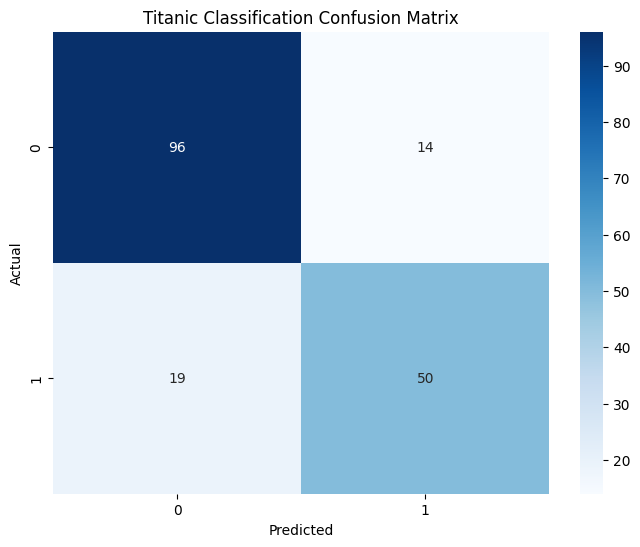

In [105]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(titanic['survived']), yticklabels=np.unique(titanic['survived']))
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Feature importances
Let's figure out how to get the feature importances of our overall model.  You'll need to know how to do this for your final project.  
First, to obtain the categorical feature importances, we have to work our way backward through the modelling pipeline to associate the feature importances with their one-hot encoded input features that were transformed from the original categorical features.

We don't need to trace back through the pipeline for the numerical features, because we didn't transfrom them into new ones in any way.  
Remember, we went from categorical features to one-hot encoded features, using the 'cat' column transformer.

Here's how you trace back through the trained model to access the one-hot encoded feature names:


In [107]:
model.best_estimator_['preprocessor'].named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out(cat_features)

array(['sex_female', 'sex_male', 'class_First', 'class_Second',
       'class_Third', 'who_child', 'who_man', 'who_woman'], dtype=object)

Let's get all of the feature importances and associate them with their transformed feature names.

In [117]:
feature_importances = model.best_estimator_['classifier'].feature_importances_

Combine the numerical and one-hot encoded categorical feature names

In [121]:
feature_names = numeric_features+list(model.best_estimator_['preprocessor']
                                      .named_transformers_['categorical']
                                      .named_steps['onehot']
                                      .get_feature_names_out(cat_features))

**Lets display the names and importances in bar plot**

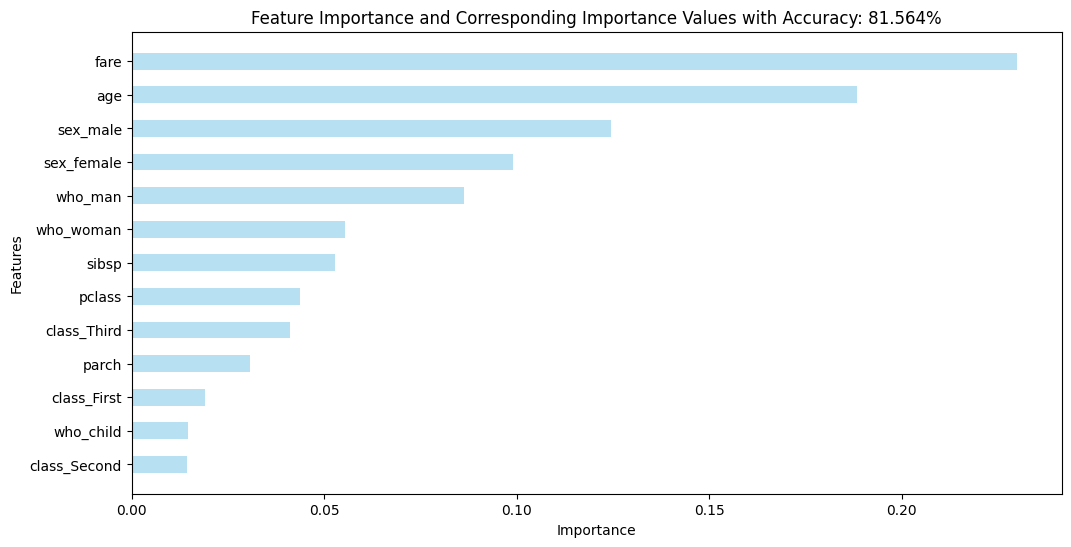

In [133]:
importance_df = pd.DataFrame({
    'Features': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=True)

# Get test score
test_score = model.score(X_test, y_test)

# Plotting
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Features'], width=importance_df['Importance'], height=0.5, color='skyblue', alpha=0.6)
plt.title(f'Feature Importance and Corresponding Importance Values with Accuracy: {100*test_score:.3f}%')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

<details><summary>Observations</summary>

The test set accuracy is somewhat satisfactory. However,regarding the feature impoirtances, it's crucially important to realize that there is most likely plenty of dependence amongst these variables, and a more detailed modelling approach including correlation analysis is required to draw proper conclusions. For example, no doubt there is significant information shared by the variables `age`, `sex_male`, and `who_man`.

## Try another model
In practice you would want to try out different models and even revisit the data analysis to improve
your model performance. Maybe you can engineer new features or impute missing values to be able to use more data.

With Scikit-learn's powerful pipeline class, this is easy to do in a few steps.
Let's update the pipeline and the parameter grid so we can train a Logistic Regression model and compare the performance of the two models.


In [138]:
# Replace RandomForestClassifier with LogisticRegression
pipeline.set_params(classifier=LogisticRegression(random_state=42))

# update the model's estimator to use the new pipeline
model.estimator = pipeline

# Define a new grid with Logistic Regression parameters
param_grids = {
    'classifier__solver':['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight':[None, 'balanced']
}
model.param_grid = param_grids

# Fit the updated pipeline with Logistic Regression
model.fit(X_train, y_train)

# Make prediction
y_pred = model.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/nareshdhami/Desktop/Visual Code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nareshdhami/Desktop/Visual Code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nareshdhami/Desktop/Visual Code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nareshdhami/Desktop/Visual Code/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: D

Display the clasification report for the new model and compare the results to your previous model.

In [145]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       110
           1       0.81      0.72      0.76        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179



<details><summary>Observations</summary>

All of the scores are slightly better for logistic regression than for random forest classification, although the differences are insignifica

**Lets work with the confusion matrix**

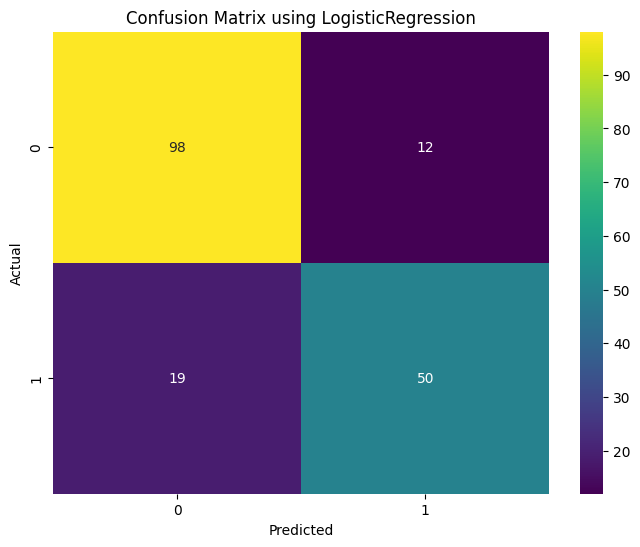

In [148]:
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix using LogisticRegression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Extract the logistic regression feature coefficients and plot their magnitude in a bar chart.**

In [164]:
coefficients = model.best_estimator_.named_steps['classifier'].coef_[0]
num_feature_names = numeric_features
cat_feature_names = model.best_estimator_.named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out(cat_features)

# Get the best features
feature_names = num_feature_names+list(cat_feature_names)

['pclass',
 'age',
 'sibsp',
 'parch',
 'fare',
 'sex_female',
 'sex_male',
 'class_First',
 'class_Second',
 'class_Third',
 'who_child',
 'who_man',
 'who_woman']

**Plot the feature coefficient magnitudes in a bar chart**

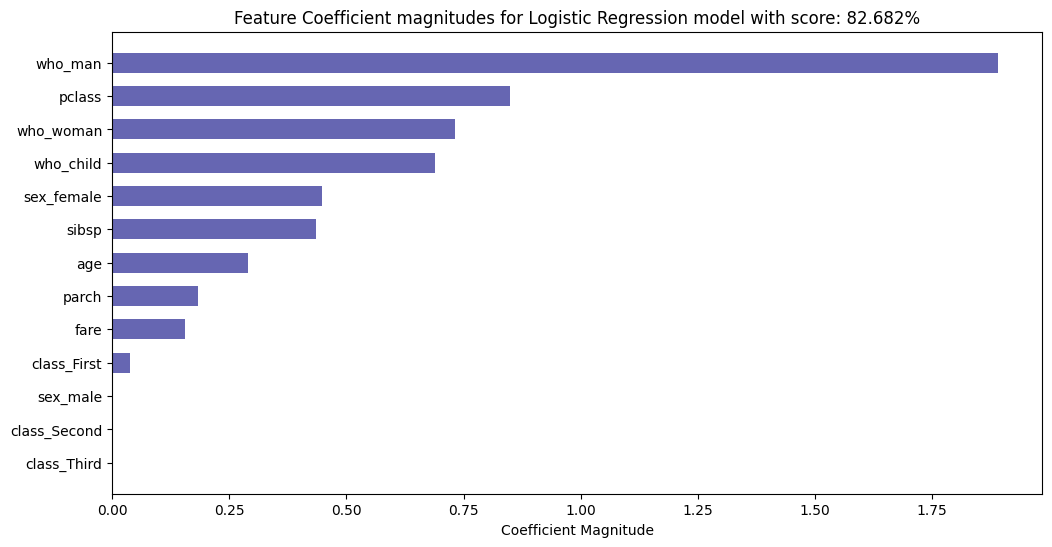

In [175]:
importance_df = pd.DataFrame({
    'Features': feature_names,
    'Coefficients': coefficients
}).sort_values(by='Coefficients', ascending=False, key=abs) # key=abs sorts ignoring -ve sign (only for sorting)

score = model.score(X_test, y_test)

# Lets plot
plt.figure(figsize=(12, 6))
plt.barh(y=importance_df['Features'], width=importance_df['Coefficients'].abs(), height=0.6, color='navy', alpha=0.6)
plt.title(f'Feature Coefficient magnitudes for Logistic Regression model with score: {100*score:.3f}%')
plt.xlabel('Coefficient Magnitude')
plt.gca().invert_yaxis()
plt.show()